In [73]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Hoax_Detection"

In [75]:
%cd /content/gdrive/My Drive/Hoax_Detection

/content/gdrive/My Drive/Hoax_Detection


In [76]:
!ls

Fake.csv  True.csv


## LOAD AND PREPARE DATA

In [77]:
import pandas as pd
import re

In [78]:
df_true = pd.read_csv('True.csv')
df_false = pd.read_csv('Fake.csv')

In [79]:
df_true.shape

(21417, 4)

In [80]:
df_false.shape

(23481, 4)

In [81]:
true_testing_manual = df_true.head(10)
false_testing_manual = df_false.head(10)
df_true.drop([0,10])
df_false.drop([0,10])

,title,text,subject,date
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [82]:
false_testing_manual.to_csv('false_testing_manual.csv')
true_testing_manual.to_csv('true_testing_manual.csv')

In [83]:
df_false["Label"] = "false"
df_true["Label"] = "true"

In [84]:
false = df_false.drop(columns=['title','subject','date'])
true = df_true.drop(columns=['title','subject','date'])

In [85]:
false.isnull().sum()

text     0
Label    0
dtype: int64

In [86]:
true.isnull().sum()

text     0
Label    0
dtype: int64

In [87]:
merge = pd.concat([false, true], axis =0)

In [88]:
merge = merge.sample(frac = 1)
merge.reset_index(inplace = True)
merge.drop(["index"], axis = 1, inplace = True)

In [89]:
merge.head()

,text,Label
0,Full Frontal host Samantha Bee returned on Mon...,false
1,WASHINGTON (Reuters) - President-elect Donald ...,true
2,OTTAWA (Reuters) - The U.S. administration is ...,true
3,Governor Rick Snyder and his emergency managem...,false
4,"We all know that Trump supporters are crazy, b...",false


## DATA PRE-PROCESSING

In [90]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string as str
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [91]:
def remove_noise(text):
    for punctuation in str.punctuation:
        text = text.replace(punctuation, '')
    return text

In [92]:
merge['text'] = merge['text'].apply(remove_noise)

In [93]:
merge['text'] = merge['text'].str.lower()

In [94]:
merge

,text,Label
0,full frontal host samantha bee returned on mon...,false
1,washington reuters presidentelect donald trum...,true
2,ottawa reuters the us administration is putti...,true
3,governor rick snyder and his emergency managem...,false
4,we all know that trump supporters are crazy bu...,false
...,...,...
44893,islamabad reuters gunmen on motorcycles opene...,true
44894,did hillary forget about her deplorable supp...,false
44895,geneva reuters hollywood actor michael dougla...,true
44896,beijing reuters a close ally of president xi ...,true


In [95]:
listStopword = set(stopwords.words('english'))
def remove_stopword(text):
  words = text.split(" ")
  not_stopword = []
  for word in words:
    if word not in listStopword:
        not_stopword.append(word)
  text = ' '.join(not_stopword)
  return text

In [96]:
merge['text'] = merge['text'].apply(remove_stopword,remove_noise)

In [97]:
merge

,text,Label
0,full frontal host samantha bee returned monday...,false
1,washington reuters presidentelect donald trum...,true
2,ottawa reuters us administration putting supp...,true
3,governor rick snyder emergency management team...,false
4,know trump supporters crazy man new york city ...,false
...,...,...
44893,islamabad reuters gunmen motorcycles opened f...,true
44894,hillary forget deplorable supporters beat in...,false
44895,geneva reuters hollywood actor michael dougla...,true
44896,beijing reuters close ally president xi jinpi...,true


## FEATURE EXTRACTION & TRAINING



In [98]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [99]:
x = merge['text']
y = merge['Label']

In [100]:
 X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [101]:
tfidf = TfidfVectorizer(max_df=0.7)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [102]:
classification = BernoulliNB()
classification.fit(tfidf_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [103]:
y_prediction = classification.predict(tfidf_test)

In [104]:
classification.score(tfidf_test,y_test)

0.9780623608017818

In [105]:
score = accuracy_score(y_test,y_prediction)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 97.81%


In [106]:
cf = confusion_matrix(y_test, y_prediction,labels=["false","true"])
cf

array([[4581,  151],
       [  46, 4202]])

In [107]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [108]:
cf_v = ConfusionMatrixDisplay(cf, display_labels=['False', 'True'])

[Text(0, 0.5, 'Actual News'),
 Text(0.5, 0, 'Predicted News'),
 Text(0.5, 1.0, 'Confusion Matrix')]

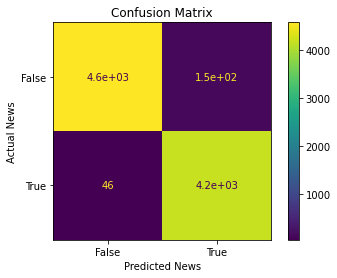

In [109]:
cf_v.plot()
cf_v.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted News', 
                ylabel='Actual News')

## VISUALIZATION

In [110]:
from matplotlib import pyplot as plt

subject
politicsNews    11272
worldnews       10145
Name: text, dtype: int64


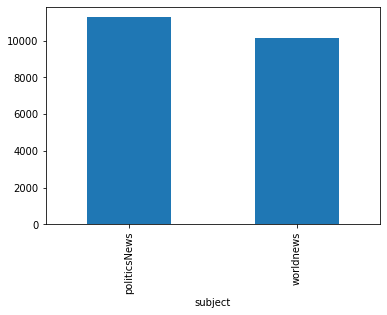

In [111]:
print(df_true.groupby(['subject'])['text'].count())
df_true.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

Label
false    23481
true     21417
Name: text, dtype: int64


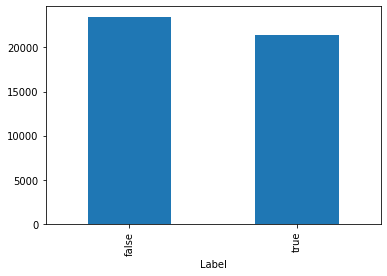

In [112]:
print(merge.groupby(['Label'])['text'].count())
merge.groupby(['Label'])['text'].count().plot(kind="bar")
plt.show()

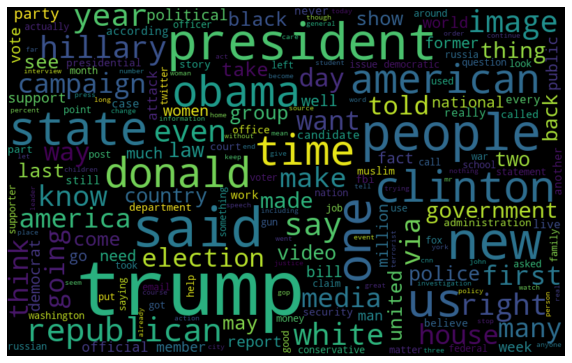

In [113]:
from wordcloud import WordCloud
fake_data = merge[merge["Label"] == "false"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

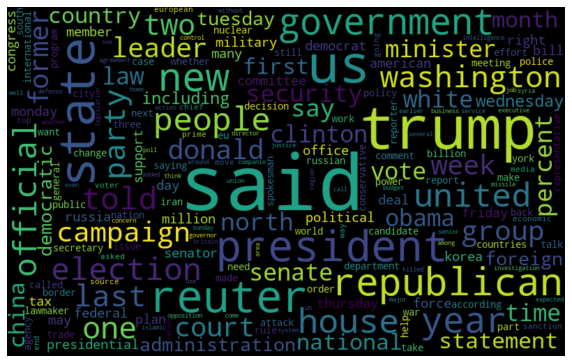

In [114]:
from wordcloud import WordCloud
true_data = merge[merge["Label"] == "true"]
all_words = ' '.join([text for text in true_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## SAVE AND LOAD MODEL

In [115]:
import pickle

In [116]:
pickle.dump(classification,open('modelfix.pkl', 'wb'))

In [117]:
# load the model from disk
loaded_model = pickle.load(open('modelfix.pkl', 'rb'))

## WORD PROOFING

In [118]:
false['Text'] = (false['text'].str.lower()).apply(remove_stopword,remove_noise)

In [119]:
true['Text'] = (true['text'].str.lower()).apply(remove_stopword,remove_noise)

In [120]:
false

,text,Label,Text
0,Donald Trump just couldn t wish all Americans ...,false,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,false,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",false,"friday, revealed former milwaukee sheriff davi..."
3,"On Christmas day, Donald Trump announced that ...",false,"christmas day, donald trump announced would b..."
4,Pope Francis used his annual Christmas Day mes...,false,pope francis used annual christmas day message...
...,...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,false,21st century wire says 21wire reported earlier...
23477,21st Century Wire says It s a familiar theme. ...,false,21st century wire says familiar theme. wheneve...
23478,Patrick Henningsen 21st Century WireRemember ...,false,patrick henningsen 21st century wireremember ...
23479,21st Century Wire says Al Jazeera America will...,false,21st century wire says al jazeera america go h...


In [122]:
true

,text,Label,Text
0,WASHINGTON (Reuters) - The head of a conservat...,true,washington (reuters) - head conservative repub...
1,WASHINGTON (Reuters) - Transgender people will...,true,washington (reuters) - transgender people allo...
2,WASHINGTON (Reuters) - The special counsel inv...,true,washington (reuters) - special counsel investi...
3,WASHINGTON (Reuters) - Trump campaign adviser ...,true,washington (reuters) - trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,true,seattle/washington (reuters) - president donal...
...,...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,true,brussels (reuters) - nato allies tuesday welco...
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",true,"london (reuters) - lexisnexis, provider legal,..."
21414,MINSK (Reuters) - In the shadow of disused Sov...,true,minsk (reuters) - shadow disused soviet-era fa...
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,true,moscow (reuters) - vatican secretary state car...


In [123]:
vectorizer = TfidfVectorizer(min_df=0.35, max_df=0.80)

In [124]:
tfIdf = vectorizer.fit_transform(false['Text'])
tfidf_false = pd.DataFrame(tfIdf[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
tfidf_false = tfidf_false.sort_values('TF-IDF', ascending=False)
print (tfidf_false.head(25))

             TF-IDF
trump      0.678385
even       0.359212
donald     0.347337
president  0.321762
like       0.219283
would      0.211054
people     0.204713
one        0.196059
also       0.116666
image      0.000000
said       0.000000
the        0.000000
time       0.000000
via        0.000000


In [125]:
tfIdf = vectorizer.fit_transform(true['text'])
tfidf_true = pd.DataFrame(tfIdf[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
tfidf_true = tfidf_true.sort_values('TF-IDF', ascending=False)
print (tfidf_true.head(25))

              TF-IDF
trump       0.357582
will        0.328051
other       0.290071
as          0.266631
we          0.259367
be          0.248014
which       0.232691
by          0.221693
who         0.182910
their       0.159973
about       0.157937
has         0.154524
also        0.152535
with        0.143793
this        0.141198
would       0.134250
not         0.121058
people      0.113536
government  0.109673
is          0.109624
or          0.109337
over        0.108612
washington  0.106114
more        0.105673
they        0.101061


In [126]:
tfidf_false.shape

(14, 1)

In [127]:
tfidf_true.shape

(53, 1)

In [128]:
tfidf_false = tfidf_false.rename_axis('word').reset_index()

In [129]:
tfidf_true = tfidf_true.rename_axis('word').reset_index()

In [130]:
tfidf_false

,word,TF-IDF
0,trump,0.678385
1,even,0.359212
2,donald,0.347337
3,president,0.321762
4,like,0.219283
5,would,0.211054
6,people,0.204713
7,one,0.196059
8,also,0.116666
9,image,0.000000


In [131]:
def falseWordProofing(inputData):
  words = inputData.split(" ")
  false_word = []
  for Word in words:
    if tfidf_false['word'].str.contains(Word).any():
        false_word.append(Word)
  result = []
  [result.append(x) for x in false_word if x not in result]
  if '' in result: result.remove('')
  return result

In [132]:
def trueWordProofing(inputData):
  words = inputData.split(" ")
  true_word = []
  for Word in words:
    if tfidf_true['word'].str.contains(Word).any():
        true_word.append(Word)
  result = []
  [result.append(x) for x in true_word if x not in result]
  if '' in result: result.remove('')
  return result

## INPUT DATA

In [ ]:
def preprocess_input(text):
  return remove_stopword(remove_noise(text.lower()))

In [133]:
def fake_news_det(news):
   news = news.lower()
   news1 = remove_stopword(news)
   news2 = remove_noise(news1)
   input_data = [news2]
   print(input_data)
   status = loaded_model.predict(tfidf.transform(input_data))
   print(status)
   print(falseWordProofing(news2)) if (status == 'false') else print(trueWordProofing(news2))
     
# def fake_news_det(news):
#    news = news.lower()
#    news1 = remove_stopword(news)
#    news2 = remove_noise(news1)
#    input_data = [news2]
#    print(input_data)
#    print(classification.predict(tfidf.transform(input_data)))

In [134]:
fake_news_det("Donald Trump spent a good portion of his day at his golf club, marking the 84th day he s done so since taking the oath of office. It must have been a bad game because just after that, Trump lashed out at FBI Deputy Director Andrew McCabe on Twitter following a report saying McCabe plans to retire in a few months. The report follows McCabe s testimony in front of congressional committees this week, as well as mounting criticism from Republicans regarding the Russia probe.So, naturally, Trump attacked McCabe with a lie. How can FBI Deputy Director Andrew McCabe, the man in charge, along with leakin  James Comey, of the Phony Hillary Clinton investigation (including her 33,000 illegally deleted emails) be given $700,000 for wife s campaign by Clinton Puppets during investigation?  Trump tweeted.How can FBI Deputy Director Andrew McCabe, the man in charge, along with leakin  James Comey, of the Phony Hillary Clinton investigation (including her 33,000 illegally deleted emails) be given $700,000 for wife s campaign by Clinton Puppets during investigation?  Donald J. Trump (@realDonaldTrump) December 23, 2017He didn t stop there.FBI Deputy Director Andrew McCabe is racing the clock to retire with full benefits. 90 days to go?!!!  Donald J. Trump (@realDonaldTrump) December 23, 2017Wow,  FBI lawyer James Baker reassigned,  according to @FoxNews.  Donald J. Trump (@realDonaldTrump) December 23, 2017With all of the Intel at Trump s disposal, he s getting his information from Fox News. McCabe spent most of his career in the fight against terrorism and now he s being attacked by the so-called president. Trump has been fact-checked before on his claim of his wife receiving $700,000 for her campaign.Politifact noted in late July that Trump s  tweet about Andrew McCabe is a significant distortion of the facts. And the implication that McCabe got Clinton off as a political favor doesn t make much sense when we look at the evidence. His July tweet was rated  mostly false.  But Trump repeats these lies because he knows his supporters will believe them without bothering to Google. It s still a lie, though.Photo by Zach Gibson   Pool/Getty Images.")

['donald trump spent good portion day golf club marking 84th day done since taking oath office must bad game that trump lashed fbi deputy director andrew mccabe twitter following report saying mccabe plans retire months report follows mccabe testimony front congressional committees week well mounting criticism republicans regarding russia probeso naturally trump attacked mccabe lie fbi deputy director andrew mccabe man charge along leakin  james comey phony hillary clinton investigation including 33000 illegally deleted emails given 700000 wife campaign clinton puppets investigation  trump tweetedhow fbi deputy director andrew mccabe man charge along leakin  james comey phony hillary clinton investigation including 33000 illegally deleted emails given 700000 wife campaign clinton puppets investigation  donald j trump realdonaldtrump december 23 2017he stop therefbi deputy director andrew mccabe racing clock retire full benefits 90 days go  donald j trump realdonaldtrump december 23 201

In [135]:
fake_news_det("WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based international energy lawyer, pleaded guilty on Oct. 30 to lying to FBI agents about contacts with people who claimed to have ties to top Russian officials. It was the first criminal charge alleging links between the Trump campaign and Russia. The White House has played down the former aide’s campaign role, saying it was “extremely limited” and that any actions he took would have been on his own. The New York Times, however, reported that Papadopoulos helped set up a meeting between then-candidate Donald Trump and Egyptian President Abdel Fattah al-Sisi and edited the outline of Trump’s first major foreign policy speech in April 2016. The federal investigation, which is now being led by Special Counsel Robert Mueller, has hung over Trump’s White House since he took office almost a year ago. Some Trump allies have recently accused Mueller’s team of being biased against the Republican president. Lawyers for Papadopoulos did not immediately respond to requests by Reuters for comment. Mueller’s office declined to comment. Trump’s White House attorney, Ty Cobb, declined to comment on the New York Times report. “Out of respect for the special counsel and his process, we are not commenting on matters such as this,” he said in a statement. Mueller has charged four Trump associates, including Papadopoulos, in his investigation. Russia has denied interfering in the U.S. election and Trump has said there was no collusion between his campaign and Moscow. ")

['washington reuters  trump campaign adviser george papadopoulos told australian diplomat may 2016 russia political dirt democratic presidential candidate hillary clinton new york times reported saturday conversation papadopoulos diplomat alexander downer london driving factor behind fbi’s decision open counterintelligence investigation moscow’s contacts trump campaign times reported two months meeting australian officials passed information came papadopoulos american counterparts leaked democratic emails began appearing online according newspaper cited four current former us foreign officials besides information australians probe federal bureau investigation also propelled intelligence friendly governments including british dutch times said papadopoulos chicagobased international energy lawyer pleaded guilty oct 30 lying fbi agents contacts people claimed ties top russian officials first criminal charge alleging links trump campaign russia white house played former aide’s campaign rol

## MANUAL TEST

In [136]:
df_manual_false = pd.read_csv('false_testing_manual.csv')
df_manual_true = pd.read_csv('true_testing_manual.csv')
false_text = df_manual_false.drop(columns=['title','subject','date'])
true_text = df_manual_true.drop(columns=['title','subject','date'])

In [137]:
for text in false_text['text']:
  fake_news_det(text)

['donald trump wish americans happy new year leave that instead give shout enemies haters  dishonest fake news media  former reality show star one job it country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year  president angry pants tweeted  2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america  donald j trump realdonaldtrump december 31 2017trump tweet went welll expectwhat kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizens happy new year  bishop talbert swan talbertswan december 31 2017no one likes  calvin calvinstowell december 31 2017your impeachment would make 2018 great year america also accept regaining control congress  miranda yaver mirandayaver december 31 2017do

In [138]:
for text in true_text['text']:
  fake_news_det(text)

['washington reuters  head conservative republican faction us congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” sunday urged budget restraint 2018 keeping sharp pivot way among republicans us representative mark meadows speaking cbs’ “face nation” drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even november congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases nondefense “discretionary” spending programs support education scientific research infrastructure public health environmental protection “the trump administration already willing say ‘we’re going increase nondefense discretionary spending  7 percent’” meadows chairman small influential house freedom caucus said p